## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

In [2]:
from random import sample
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import math
import seaborn as sns

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3218970948243875609
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13757070659681039115
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338085172
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11683700527326888620
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11115688934179298809
physical_device_desc: "device: XLA_GPU device"
]


## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df

In [5]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [6]:
all_image_paths = {os.path.basename(x):x for x in 
                  glob(os.path.join('/data', 'images*', '*', '*.png'))}
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png


In [7]:
findings = set()
for finding in all_xray_df['Finding Labels'].unique():
    findings.update(finding.split('|'))
print("Single diagnoses qty:", len(findings), findings)

Single diagnoses qty: 15 {'Mass', 'Effusion', 'Edema', 'Infiltration', 'Hernia', 'Pneumonia', 'No Finding', 'Pneumothorax', 'Cardiomegaly', 'Fibrosis', 'Atelectasis', 'Consolidation', 'Emphysema', 'Nodule', 'Pleural_Thickening'}


There are 15 unique types of labels found in the dataset

In [8]:
for finding in findings:
    all_xray_df[finding] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pneumonia,No Finding,Pneumothorax,Cardiomegaly,Fibrosis,Atelectasis,Consolidation,Emphysema,Nodule,Pleural_Thickening
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: 'Y' if x['Pneumonia'] == 1.0 else 'N', axis=1)
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,No Finding,Pneumothorax,Cardiomegaly,Fibrosis,Atelectasis,Consolidation,Emphysema,Nodule,Pleural_Thickening,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,N
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [10]:
(all_xray_df[findings].sum()/len(all_xray_df))*100

Mass                   5.156975
Effusion              11.877453
Edema                  2.054049
Infiltration          17.743489
Hernia                 0.202462
Pneumonia              1.276311
No Finding            53.836068
Pneumothorax           4.728862
Cardiomegaly           2.475919
Fibrosis               1.503746
Atelectasis           10.309490
Consolidation          4.162504
Emphysema              2.244024
Nodule                 5.646629
Pleural_Thickening     3.019087
dtype: float64

[Text(0, 0.5, 'Labeled Images')]

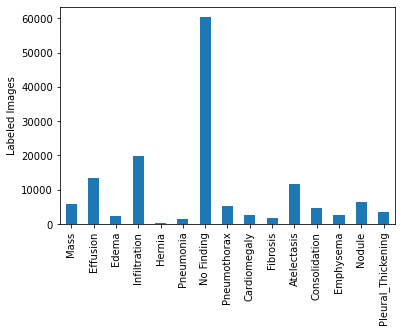

In [11]:
#check distribution
ax = all_xray_df[findings].sum().plot(kind ='bar')
ax.set(ylabel = 'Labeled Images')

In [12]:
#Prune categories with less than 1000 cases
#MIN_CASES = 1000
#all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
#print('Clean Labels ({})'.format(len(all_labels)), 
#      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])


In [13]:
#check distribution
#ax = all_xray_df[all_labels].sum().plot(kind ='bar')
#ax.set(ylabel = 'Labeled Images')

## Create your training and testing data:

In [14]:
def create_splits(**vargs):
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    df = vargs['df']
    train_df, valid_df = skl.train_test_split(df,
                                              test_size = 0.2,
                                              stratify = df['pneumonia_class'])
    #Initial Split
    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Initial split. Train set pneumonia: {100.0*train_df_ratio :.2f}%. Validation set pneumonia: {100 * valid_df_ratio :.2f}%')
    
    #Correct training set to contain equal number of positive and negative cases
    #obtain index
    train_pos_inds = train_df[train_df['pneumonia_class'] == 'Y'].index.tolist()
    train_neg_inds = train_df[train_df['pneumonia_class'] == 'N'].index.tolist()
    #use sample to choose len(train_pos_inds) unique random elements from a population sequence or set
    train_neg_sample = sample(train_neg_inds, len(train_pos_inds))
    train_df = train_df.loc[train_pos_inds + train_neg_sample]
    
    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    print(f'Training set 50/50 split, pneumonia: {100.0 * train_df_ratio :.2f}%')
    
    #correct validation set to contain 80% positive and 20% negative cases
    valid_pos_inds = valid_df[valid_df['pneumonia_class'] == 'Y'].index.tolist()
    valid_neg_inds = valid_df[valid_df['pneumonia_class'] == 'N'].index.tolist()

    valid_neg_sample = sample(valid_neg_inds, 4*len(valid_pos_inds))
    valid_df = valid_df.loc[valid_pos_inds + valid_neg_sample]

    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Validation set 20/80, pneumonia: {100.0*valid_df_ratio :.2f}%')

    return train_df, valid_df                
    

In [15]:
df_train, df_valid = create_splits(df = all_xray_df)
print(f'Training set size: {len(df_train)}, validation set size: {len(df_valid)}')

Initial split. Train set pneumonia: 1.28%. Validation set pneumonia: 1.28%
Training set 50/50 split, pneumonia: 50.00%
Validation set 20/80, pneumonia: 20.00%
Training set size: 2290, validation set size: 1430


In [16]:
df_valid.shape

(1430, 29)

In [17]:
df_valid.shape

(1430, 29)

In [18]:
df_train['pneumonia_class'].value_counts()

Y    1145
N    1145
Name: pneumonia_class, dtype: int64

In [19]:
df_valid['pneumonia_class'].value_counts()

N    1144
Y     286
Name: pneumonia_class, dtype: int64

Text(0.5, 1.0, 'Pneumonia_class (Training Data)')

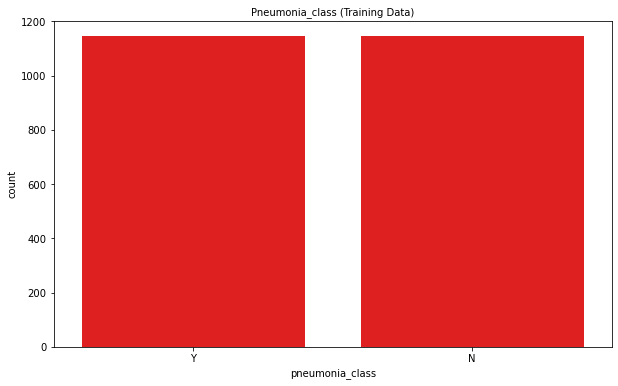

In [20]:
f, ax = plt.subplots(sharex=True,figsize=(10, 6))
g=sns.countplot(x='pneumonia_class',data=df_train, ax=ax, order = df_train['pneumonia_class'].value_counts().index,color='r',label="Training Data")
ax.set_title("Pneumonia_class (Training Data)",fontsize=10)      

Text(0.5, 1.0, 'Pneumonia_class (Training Data)')

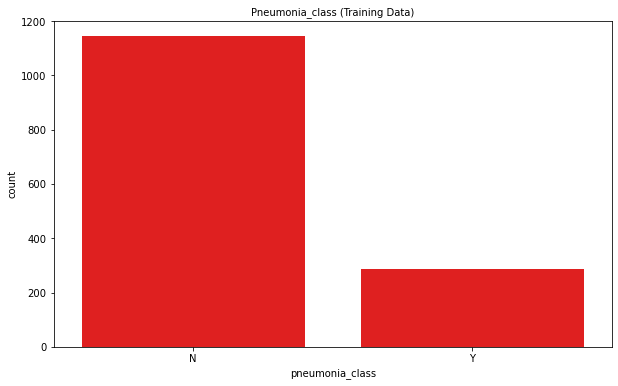

In [21]:
f, ax = plt.subplots(sharex=True,figsize=(10, 6))
g=sns.countplot(x='pneumonia_class',data=df_valid, ax=ax, order = df_valid['pneumonia_class'].value_counts().index,color='r',label="Training Data")
ax.set_title("Pneumonia_class (Training Data)",fontsize=10)      

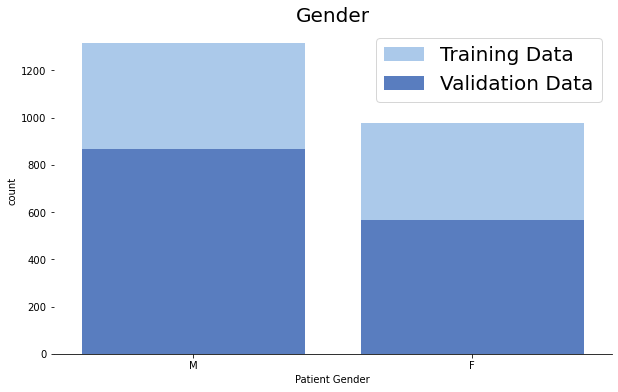

In [22]:
f, ax = plt.subplots(sharex=True,figsize=(10, 6))
sns.set_color_codes("pastel")
g=sns.countplot(x='Patient Gender',data=df_train, ax=ax, order = df_train['Patient Gender'].value_counts().index,color='b',label="Training Data")
sns.set_color_codes("muted")
g=sns.countplot(x='Patient Gender',data=df_valid, ax=ax, color="b",label="Validation Data")
ax.legend( loc="upper right", frameon=True,fontsize=20)
#ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Gender",fontsize=20)      
sns.despine(left=True)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


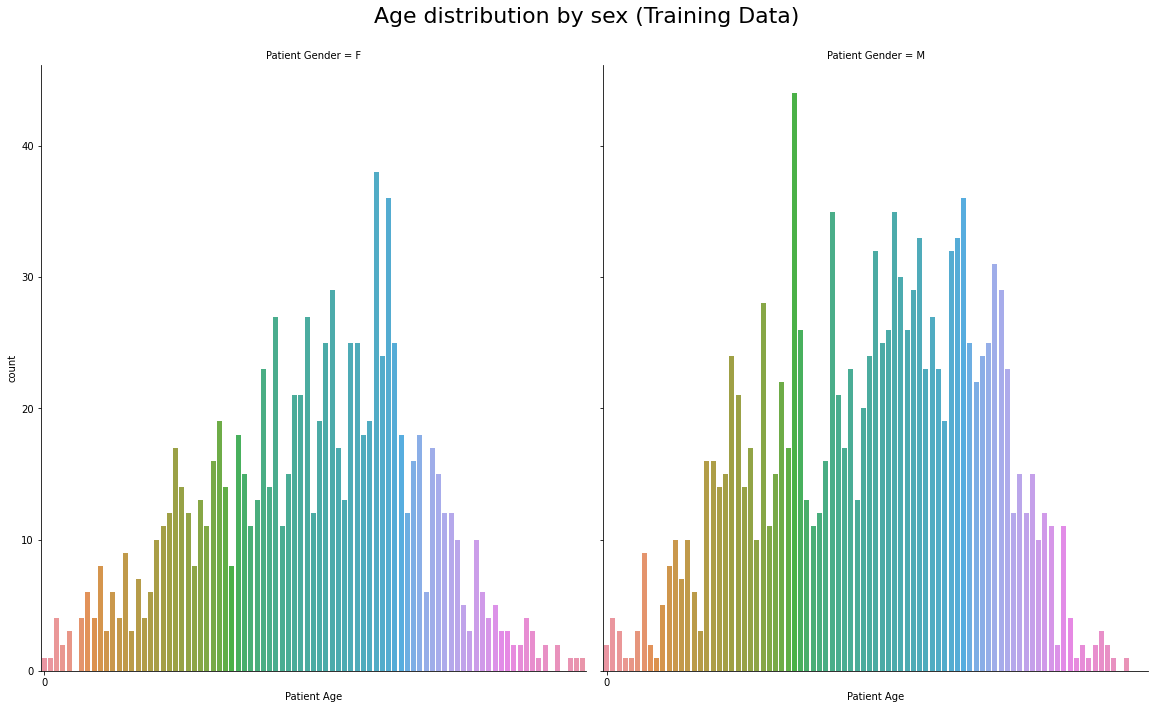

In [23]:
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=df_train, kind="count",size=10, aspect=0.8,palette=None);
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex (Training Data)',fontsize=22);
g.fig.subplots_adjust(top=.9)

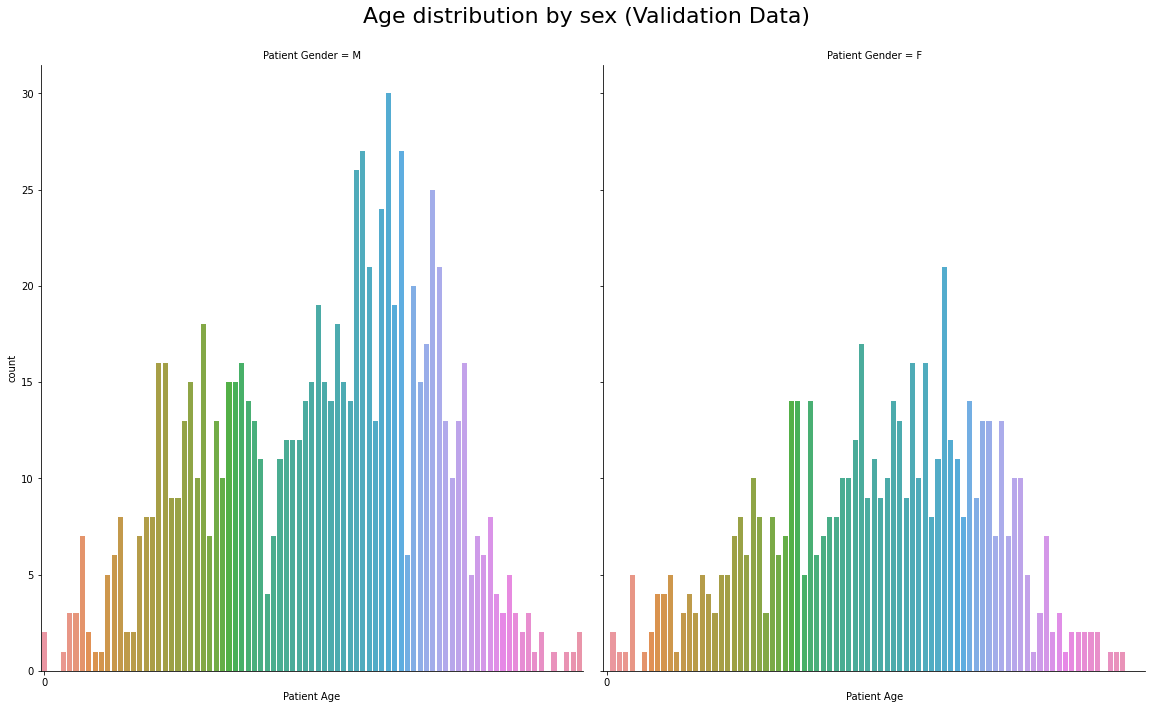

In [24]:
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=df_valid, kind="count",size=10, aspect=0.8,palette=None);
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex (Validation Data)',fontsize=22);
g.fig.subplots_adjust(top=.9)

## Now we can begin our model-building & training

In [25]:
IMAGE_SIZE = (224, 224)

def my_image_augmentation(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo 
    rotation = vargs['rotation'] if 'rotation' in vargs else 20
    shear = vargs['shear'] if 'shear' in vargs else 0.1
    zoom = vargs['zoom'] if 'rotation'in vargs else 0.1
    
    my_idg = ImageDataGenerator(rescale = 1. / 255.0,
                                samplewise_center=True,
                                samplewise_std_normalization= True, 
                                horizontal_flip = True,
                                vertical_flip = False,
                                height_shift_range = 0.1,
                                width_shift_range = 0.1,
                                rotation_range = rotation,
                                shear_range = shear, 
                                zoom_range = zoom)
    return my_idg

def make_train_gen(**vargs):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    df = vargs['df']
    aug = my_image_augmentation(**vargs)
    
    train_gen = aug.flow_from_dataframe(dataframe = df,
                                        directory = None,
                                        x_col = 'path',
                                        y_col = 'pneumonia_class',
                                        class_mode = 'binary',
                                        target_size = IMAGE_SIZE,
                                        batch_size = 32)
    
    return train_gen


def make_val_gen(**vargs):
    # Todo
    df = vargs['df']
    aug = my_image_augmentation(**vargs)
    val_gen = aug.flow_from_dataframe(dataframe = df, 
                                      directory = None,
                                      x_col = 'path',
                                      y_col = 'pneumonia_class',
                                      class_mode = 'binary',
                                      target_size = IMAGE_SIZE,
                                      batch_size = 1024)
                                        
                                        
    return val_gen

In [26]:
train_gen = make_train_gen(df = df_train)
valid_gen = make_val_gen(df = df_valid)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [27]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = valid_gen.next()

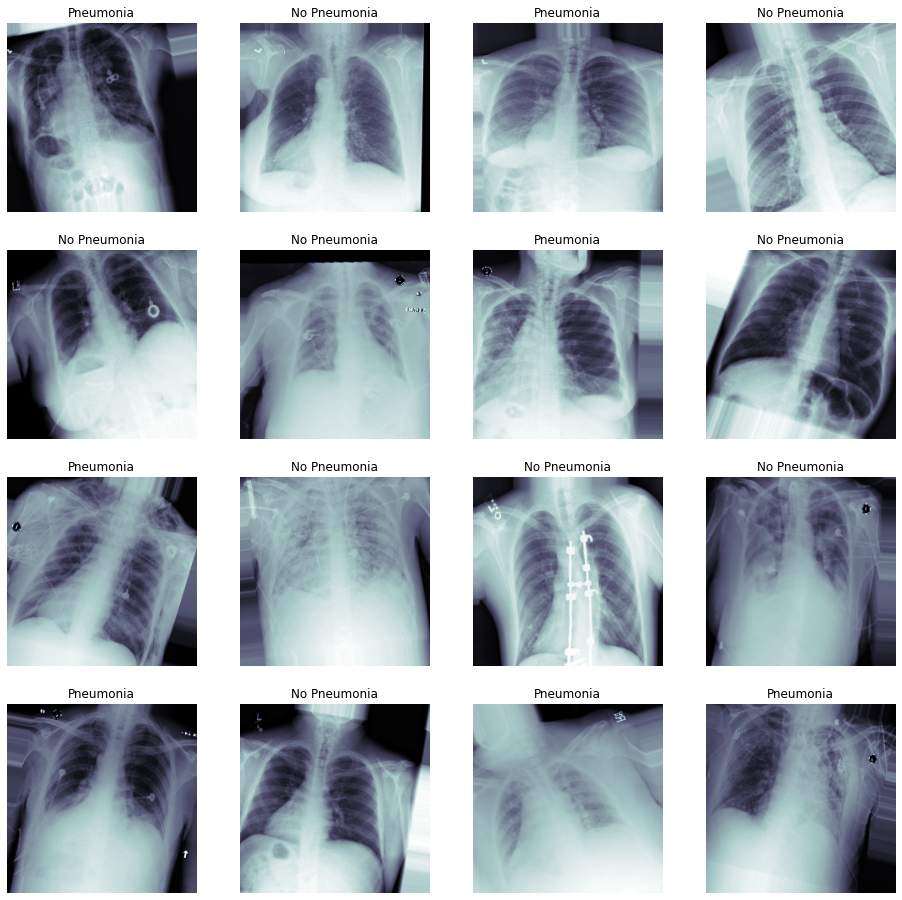

In [28]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
    
plt.show()

These look reasonable from a medical imaging point of view.

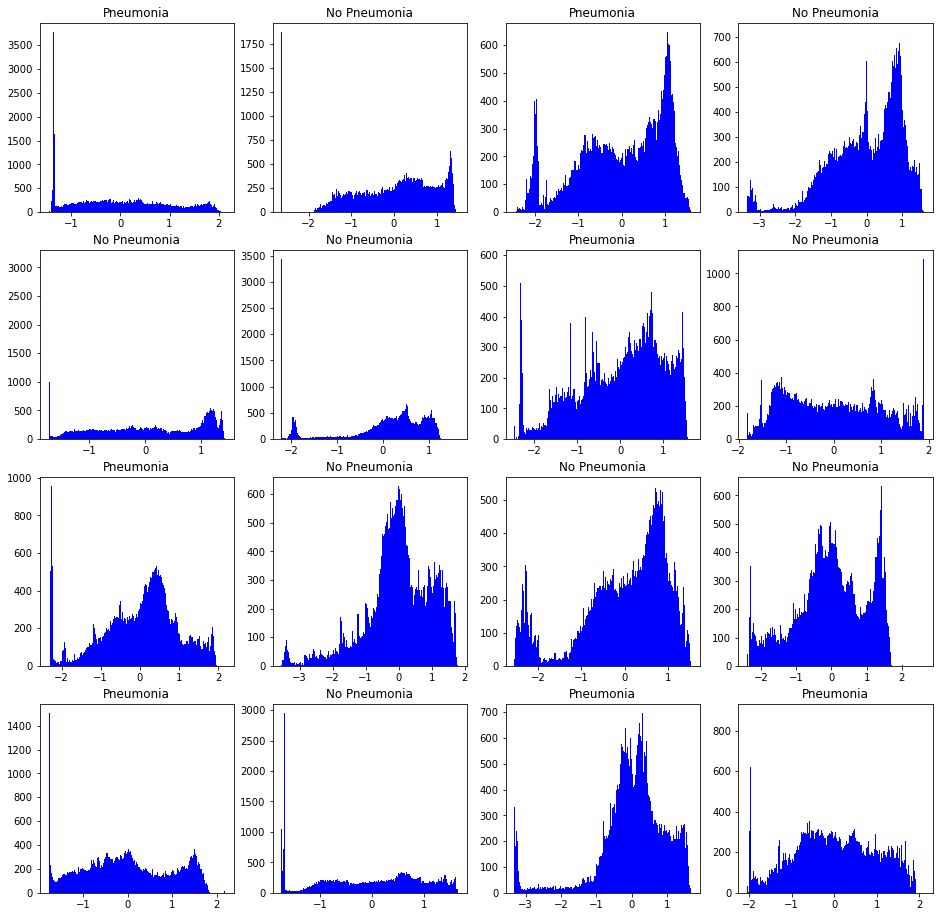

In [29]:
# t_x, t_y = next(train_gen)

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     mask = (data > 0.1) & (data < 0.9)
#     d = data[mask].flatten()
    c_ax.hist(c_x[:,:,0].flatten(), bins = 256, color='blue')
    
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')

plt.show()

## Build your model:

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning


In [30]:
def load_pretrained_model():
    #Now we'll load in VGG16 with pre-trained ImageNet weights
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
    ## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    print('verification of VGG16')
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    return vgg_model

In [31]:
def build_my_model(**vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model = load_pretrained_model()
    new_model = Sequential()
    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())
    
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.4))
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.3))
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(256, activation='relu'))
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.2))
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(128, activation='relu'))
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.1))
    
    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))
    
    return new_model

In [32]:
model = build_my_model()
model.summary()

553467904/553467096 [==============================] - 6s 0us/step
verification of VGG16
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (D

## Start training!

In [33]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo
# define learning rate, loss, metrics and compile
optimizer = Adam(lr=5e-6)
#optimizer = Adam(lr=1e-6)
#optimizer = Adam(lr=3e-4)
#optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# define callbacks
weight_path="{}_model3.best.hdf5".format('xray_classification')
checkpoint = ModelCheckpoint(weight_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=20)
callbacks_list = [checkpoint, early]

# train the model
history = model.fit_generator(
    train_gen, 
    validation_data = (valX, valY), 
    epochs = 60,
    callbacks = callbacks_list)

Epoch 1/60
72/72 [==============================] - 77s 1s/step - loss: 0.7225 - binary_accuracy: 0.5083 - val_loss: 0.5886 - val_binary_accuracy: 0.8086

Epoch 00001: val_loss improved from inf to 0.58862, saving model to xray_classification_model3.best.hdf5
Epoch 2/60
72/72 [==============================] - 62s 864ms/step - loss: 0.7059 - binary_accuracy: 0.5183 - val_loss: 0.6168 - val_binary_accuracy: 0.7773

Epoch 00002: val_loss did not improve from 0.58862
Epoch 3/60
72/72 [==============================] - 63s 877ms/step - loss: 0.6967 - binary_accuracy: 0.5415 - val_loss: 0.6300 - val_binary_accuracy: 0.7412

Epoch 00003: val_loss did not improve from 0.58862
Epoch 4/60
72/72 [==============================] - 62s 862ms/step - loss: 0.6892 - binary_accuracy: 0.5528 - val_loss: 0.6094 - val_binary_accuracy: 0.7480

Epoch 00004: val_loss did not improve from 0.58862
Epoch 5/60
72/72 [==============================] - 62s 864ms/step - loss: 0.6875 - binary_accuracy: 0.5450 - val

72/72 [==============================] - 62s 859ms/step - loss: 0.6262 - binary_accuracy: 0.6511 - val_loss: 0.5769 - val_binary_accuracy: 0.7021

Epoch 00039: val_loss did not improve from 0.56604
Epoch 40/60
72/72 [==============================] - 62s 862ms/step - loss: 0.6308 - binary_accuracy: 0.6441 - val_loss: 0.6270 - val_binary_accuracy: 0.6553

Epoch 00040: val_loss did not improve from 0.56604
Epoch 41/60
72/72 [==============================] - 62s 862ms/step - loss: 0.6228 - binary_accuracy: 0.6528 - val_loss: 0.5918 - val_binary_accuracy: 0.6914

Epoch 00041: val_loss did not improve from 0.56604
Epoch 42/60
72/72 [==============================] - 62s 859ms/step - loss: 0.6234 - binary_accuracy: 0.6520 - val_loss: 0.5957 - val_binary_accuracy: 0.6846

Epoch 00042: val_loss did not improve from 0.56604
Epoch 43/60
72/72 [==============================] - 63s 869ms/step - loss: 0.6188 - binary_accuracy: 0.6642 - val_loss: 0.6123 - val_binary_accuracy: 0.6650

Epoch 00043: 

![](img/l3-loss.png)

After a model is built the part above shows how it is trained. It's important to know when to stop training so that the performance is maximized on a hold-out validations set. Monitoring the performance of the model on both training and validation sets is informative.

This training set of data is fed into the model over and over again, while it tries to learn important features of the data. Each time the entire dataset is passed through the model, we call this one epoch. At each epoch, we  apply augmentation to some of the training images so that the model doesn't see quite the same images every single time. At the end of each epoch, the model has something called a loss function to calculate how different it's prediction is from the ground truth of the training image.

If the loss is small, it means the model did well in classifying the training images that it saw in that epoch. The model then uses the training loss to go back and update the weights of every single filter in the layers that are being trained. This technique is called backpropagation.

Backpropagation updates weights in a way that makes weights more accurate in the next epoch. Once these weights are updated, the training data is processed again in a second epoch, and the process repeats.

Choosing how many epochs to train for is important. Training as many epochs as possible is not always useful and may result in the model overfitting hence early stopping has been implemented here.

The loss function is also used to evaluate the loss on the held-out validation set. That is calculate a validation loss that measures how the prediction matches the validation data. Same here, a smaller loss indicates that the model did while classifying a validation image, except for at this step, we don't update the weights. The validation set is just a test of performance of the model, not teaching it how to be better.

![](img/l3-over.png)

The loss function is evaluated on both the training and validation sets. So there is a training loss and a validation loss at the end of each epoch that we can use to monitor the model's performance.

Lower loss means higher performance. If the model is learning from the training data, after several epochs, the training loss goes down. Since the validation is something that the algorithm never seen, if the model is truly learning about what the real-world looks like, the validation loss will also go down.

Over many epochs, the training loss continues to decrease as the model learns the features that discriminate classes in this particular set of images better and better.

At a certain point the loss plateaus, because the model cannot learn how to discriminate between image classes any better with its current architecture and parameters.

Now, while this may look great, in that the model learned a lot about how to discriminate classes in the training data, what we really care about is how it's performing on the validation data, or the data that it is not using to update its weights from.

Oftentimes, the validation loss dips, then rises, then dips again and plateaus. This occurs when the model is still learning how to better classify the training data, but not the validation data, it's called Overfitting.

Ideally the graph shows smooth loss functions, where the loss decreases in both training and validation data over a longer period of time. 

A function in Keras called Fit generator is given the training and validation data. The output of the training is set to a variable called history. Then different fields of this history variable will be used to extract loss values from the training and validation sets over time.

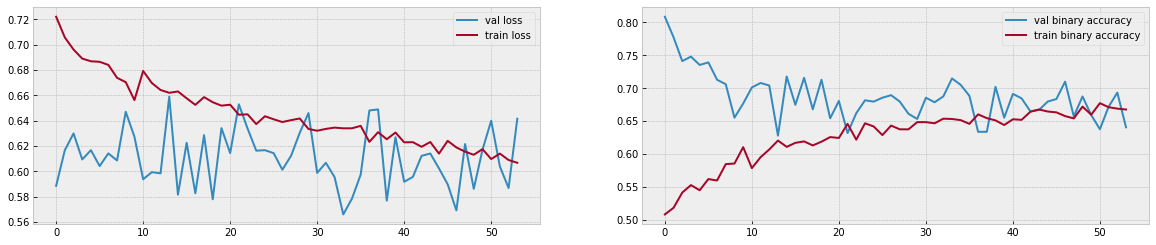

In [34]:
#optimizer = Adam(lr=5e-6) 50 epochs
f = plt.figure()
f.set_figwidth(20)    
plt.style.use('bmh')
f.add_subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

f.add_subplot(1, 2, 2)
plt.plot(history.history['val_binary_accuracy'], label='val binary accuracy')
plt.plot(history.history['binary_accuracy'], label='train binary accuracy')
plt.legend()

plt.show()

As mentioned above each time the entire training data is passed through the neural network, this is calledone epoch. At the end of each epoch, the model has a loss function to calculate how different its prediction from the ground truth of the training image, this difference is the training loss. The network then uses back-propogation technique which uses the training loss to update the weights of filters. 

At the end of each epoch, the loss function is also used to to evaluate the loss on the validation set and obtain a validation loss that measures how the prediction matches the validation data. But the weights are not updated  using validation loss. The validation set is just to test the performance of the model.

If the loss is small, it means the model did well classifying the images that it saw in that epoch.

If the training loss keeps going down while the validation loss stops decreasing after a few epochs, thid is refered to as the model is overfitting. It suggests the model is still learning how to better classify the training data but NOT the validation data. 

The above shows that the model is slightly overfitting since the training loss is decreasing but the validation loss is jumping around although is is decreasing over time

To avoid overfitting, we can A) changing the model’s architecture, or B) changing some of the parameters. Some parameters to change are:

-    Batch size
-    Learning rate
-    Dropout
-    More variation on training data

This will be left to a later time.

In [35]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1024/1024 [==============================] - 9s 9ms/step


In [36]:
# make a prediction
ynew = model.predict_classes(valX)

In [37]:
print ('Confusion Matrix :')
print(confusion_matrix(valY, ynew))

Confusion Matrix :
[[628 199]
 [ 93 104]]


In [38]:
tn, fp, fn, tp = confusion_matrix(valY, ynew).ravel()
(tn, fp, fn, tp)

(628, 199, 93, 104)

In [39]:
print('Report : ')
print(classification_report(valY, ynew))

Report : 
              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81       827
         1.0       0.34      0.53      0.42       197

    accuracy                           0.71      1024
   macro avg       0.61      0.64      0.61      1024
weighted avg       0.77      0.71      0.74      1024



## Model evaluation notes

### Confusion Matrix
![](img/l1-performance-2.png)

The above table shows the results of comparing a models prediction to the real label with respect to a cancer study. The table can be turned into the confusion matrix below.

![](img/l1-performance-1.png)

**Definitions**
-    **TP**: (True Positives) Sick patient that we correctly diagnosed as pneumonia positive.
-    **TN**: (True Negatives) Healthy patient that we correctly diagnosed as pneumonia negative.
-    **FP**: (False Positives) Healthy patient that we incorrectly diagnosed as pneumonia positive.
-    **FN**: (False Negatives) Sick patient that we incorrectly diagnosed as pneumonia negative.

Note: TP and TF the model predicted correctly. TN TF the model did NOT predict correctly

______________________________________________________________

**Accuracy**: $\frac{TP + TN}{sum of all points}$measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).
   - not a good indicator of model performance, if  class distribution is imbalanced (one class is more frequent than others)
   - in the case of this clinical dataset this metric will not be considered since pneumonia cases are such a small part of the dataset
   
______________________________________________________________

![](img/sensitivity1.png)

**Sensitivity**: $\frac{TP}{TP + FN}$ Proportion of accurately-identified **positive cases** a.k.a **the true positive rate and recall**. Recall is really important, clinically. Because in medicine, it is much more important to find disease cases. In other words, the goal is to find positive cases, rather than finding normal cases (negative cases). This metric tells us how often we correctly find a positive case. Notice that this metric takes nothing into account about **FP false positives**. So if the model says the case is positive, but it's actually negative, we wouldn't know. If the model predicted positive for every image in the dataset, we'd find all the disease cases, but that would still wouldn't be very useful, would it? 
- calculates the number of positive cases identified by the model, divided by all of the positive cases in the dataset. In other words, measures the proportion of accurately identified positive cases. 
- highly sensitive tests are good for ruling out disease. If someone has a **negative result** on a highly sensitive model, it is extremely likely that they don’t have the disease since a high sensitive model has low false negative.
- Good for ruling out disease
- **clinical setting**: good for screening studies where we can definitibely say if someone does not have a disease, and then follow up with any positive test results

_____________________________________________________
        
![](img/specificty.png)

**Specificity**: $\frac{TN}{TN + FP}$ Proportion of accurately-identified **negative cases** This measure looks at the number of negative cases accurately identified by the model, and divides it by all of the negative cases in the dataset, giving the proportion of accurately identified **negative cases** in the dataset. This holds value, but it's not the measure most commonly used in clinical tests.  Because normal cases (negative cases), take the majority of all of the cases we see in the real world. So the dataset is almost always imbalanced with more negative cases than positive. Just like accuracy, specificity would be really high, even if the model labels all cases as negative, since it measures the proportion of accurately identified negative cases. It's not that helpful. Another issue with specificity is that it does not take true positives into account at all, which is what we care about when we are trying to identify the disease. 
   - measures ALL the negative cases in the dataset, how many of them are successfully identified by the model, i.e. the true negatives. In other words, it measures the proportion of accurately-identified negative cases.
   - highly specific tests as being good for ruling in disease. If someone has a **positive result** on a highly specific test, it is extremely likely that they have the disease since a high specific model has low false positive. 
    - **clinical setting**: not as useful but one application could be early detection pregnancy test. If positive she is definitely pregnant, whereas if it's negative, it doesn't mean much and she will need another, more sensitive test to confirm if she is truly pregnant

So **specificity** ignored **true positives**, and **sensitivity, or recall**, didn't take into account **false positives**.

_________________________________________________

![](img/l4-pre.png)

**Precision**: $ \frac{TP}{TP + FP}$  Looks at the number of positive cases accurately identified by the model, divided by all of the cases identified as positive by the model, no matter whether they were identified right or wrong. This metric is commonly referred to as the positive predictive value. Precision is a great metric to optimize for when the target is confidence in positive results. A high precision test gives more confidence that a positive test result is actually positive. This metric, however, does not take false negatives into account. So a high precision test could still miss a lot of positive cases. Because of this, high precision tests don't necessarily make for great standalone diagnostics, but they're beneficial when you want to confirm a suspected diagnosis.  

_________________________________________________

**Recall**: $ \frac{TP}{TP + FN} $ Of all the people who are sick, how many did we diagnose as being sick? Recall, on the other hand, allows us to confidently rule out disease. When a test with high recall returns a negative result, you can be pretty confident that the result is truly negative. Recall does not take false positives into account though, so you may have a really high recall, but you're still labeling a lot of negative cases as positive. 

_________________________________________________

**Precision and recall**

A high precision test gives more confidence that a positive test result is actually positive since a high precision test has low false positive. This metric, however, does not take false negatives into account. So a high precision test could still miss a lot of positive cases. Because of this, high-precision tests don’t necessarily make for great stand-alone diagnostics but are beneficial when the goal is to confirm a suspected diagnosis.

When a high recall test returns a negative result, one can be confident that the result is truly negative since a high recall test has low false negatives. Recall does not take false positives into account though, so you may have high recall but are still labeling a lot of negative cases as positive. Because of this, high recall tests are good for things like screening studies, where you want to make sure someone doesn’t have a disease or worklist prioritization where you want to make sure that people without the disease are being de-prioritized.

Optimizing one of these metrics usually comes at the expense of sacrificing the other.


_________________________________________________

**Threshold**

The model outputs a probability ranging from 0-1 that indicates how likely the image belongs to a class. A cut-off value called threshold is used to assist in making the decision if the probability is high enough to belong to one class. Recall and precision vary when a different threshold is chosen.

_________________________________________________

**Precision-recall curve**

![](img/l4-prc.png)

recall and precision values vary when different thresholds are chosen? Rather than manually calculating all of these different scenarios for the model, will generate something called a precision-recall curve. Each point along the graph represents a different threshold value. 

The threshold value chooses whether to maximize precision or maximize recall, the curve helps to visually select the vlaue.

Precision-recall curve plots recall in the x-axis and precision in the y-axis. Each point along the curve represents precision and recall under a different threshold value.

_________________________________________________

**F1 score**

For binary classification problems, there's a score called the F1 score, which combines both precision and recall and allows us to better measure a test accuracy when there are class imbalances. Mathematically, it is the harmonic mean of precision and recall. F1 score is often used to indicate the models final performance, since it is maximized when precision and recall are balanced, simplifing reporting a bit since it only requires reporting on a single metric.

For binary classification problems, the F1 score combines both precision and recall. F1 score allows us to better measure a test’s accuracy when there are class imbalances. Mathematically, it is the harmonic mean of precision and recall.

_________________________________________________

**F1 Score**
- weighted harmonic mean of percision and recall

F1 Score = 2 * $\frac{Precision∗Recall}{Precision+Recall}$

In [40]:
#print('Confusion Matrix :')
#print(confusion_matrix(valY, ynew))
#tn, fp, fn, tp = confusion_matrix(valY, ynew).ravel()
#print(tn, fp, fn, tp)
#print('Report : ')
#print(classification_report(valY, ynew))

In [41]:
def plot_auc(t_y, p_y):
    f, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('bmh')
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR',fontsize=12)
    plt.ylabel('TPR',fontsize=12)
    plt.title('ROC Curve',fontsize=15)  
    plt.show()

## what other performance statistics do you want to include here besides AUC? 

def plot_pr(t_y, p_y):
    f, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('bmh')
    axes = plt.gca()
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.step(recall, precision, color='b', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.7, color='r')
    plt.xlabel('Recall' ,fontsize=12)
    plt.ylabel('Precision',fontsize=12)
    axes.set_ylim([0,0.6])
    plt.title('Precision-Recall Curve',fontsize=15)
    plt.show()

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

    
# Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('bmh')
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset" ,fontsize=15)
    plt.xlabel("Epoch #" ,fontsize=12)
    plt.ylabel("Loss/Accuracy" ,fontsize=12)
    plt.legend(loc="upper left")

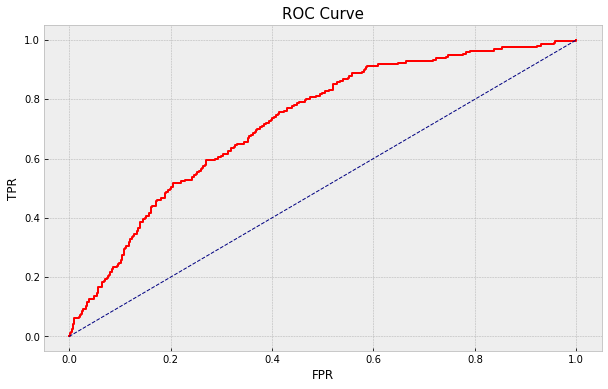

In [42]:
## plot figures
plot_auc(valY, pred_Y)

The Reciever Operator Characteristic Curve (ROC) above sumarizes the True Postiive Rate (TPR, y-axis)       and False Positive Rate (FPR, x-axis) TPR, which is the same as Sensitivity, tells us what portion of       pneumonia samples were correctly classified. FPR, tells us the proportion of non pneumonia samples tha      t were incorrectly classifed and are False Positive.

- True Positive Rate = Sensitivity = True Positive/(True Positive + False Negatives)
- False Postive Rate = 1 - Specifcity = False Positive/(False Positive + True Negatives)


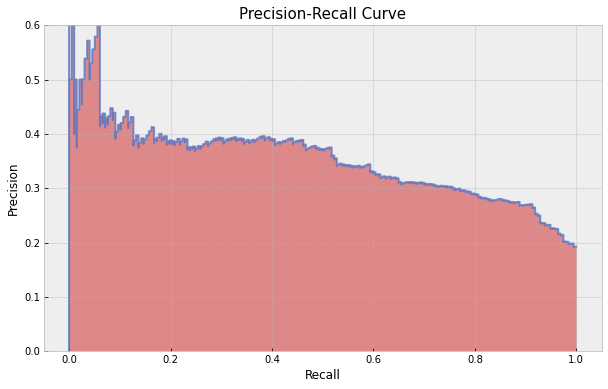

In [43]:
plot_pr(valY, pred_Y)

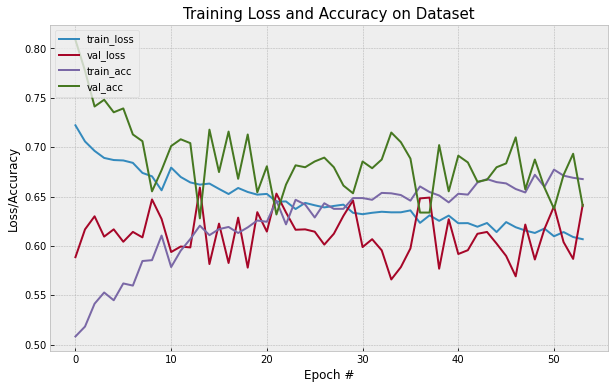

In [44]:
plot_history(history)

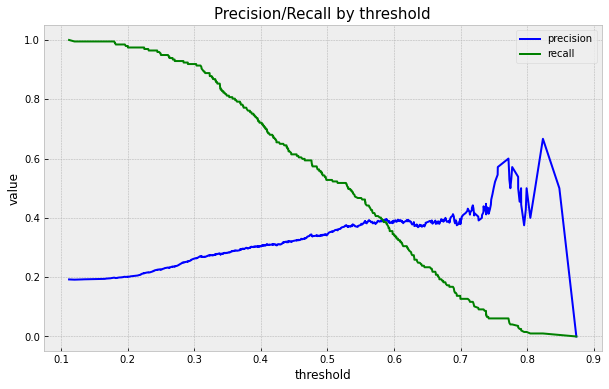

In [45]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)
f, ax = plt.subplots(figsize=(10, 6))
plt.style.use('bmh')
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold',fontsize=12)
plt.ylabel('value',fontsize=12)
plt.title('Precision/Recall by threshold',fontsize=15)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


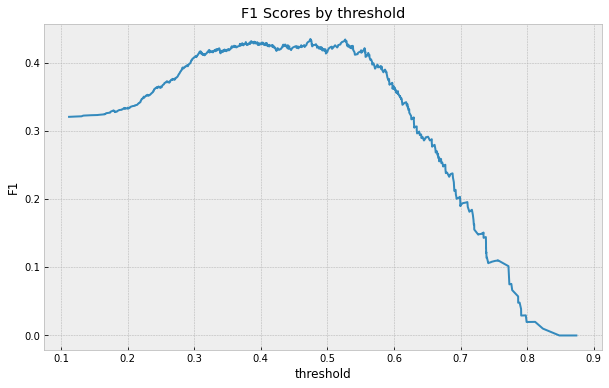

In [46]:
th = 0.5

def f1(threshold):
    for i,t in enumerate(thresholds):
        if t > threshold:
            f1score = calc_f1(precision[i], recall[i])
            if not math.isnan(f1score):
                return f1score
            else: 
                return 0
    return 0

f1scores = [f1(t) for t in thresholds]
f, ax = plt.subplots(figsize=(10, 6))
plt.plot(thresholds, f1scores)
plt.title('F1 Scores by threshold')
plt.xlabel('threshold')
plt.ylabel('F1')
plt.show()

In [47]:
ind = np.argmax(np.array(f1scores, dtype=np.float32))
f1 = f1scores[ind]
print(f'Max F1 score: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}')

Max F1 score: 0.436, threshold: 0.474, precision: 0.343, recall: 0.594


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 


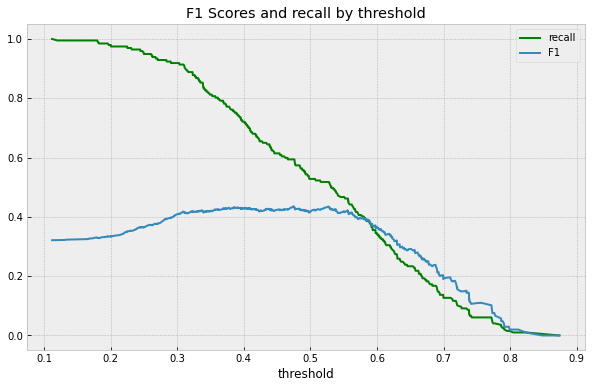

In [48]:
f, ax = plt.subplots(figsize=(10, 6))
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, label='F1')
plt.xlabel('threshold')
plt.title('F1 Scores and recall by threshold')
plt.legend()
plt.show()

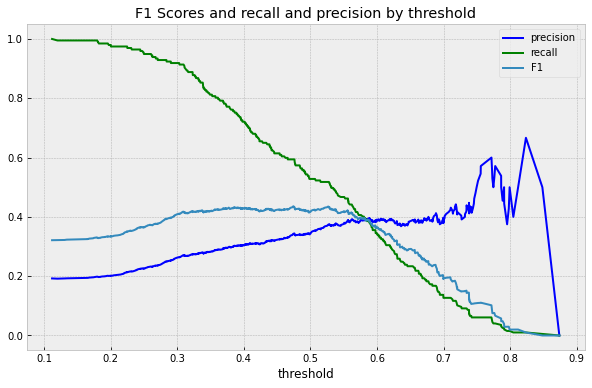

In [49]:
f, ax = plt.subplots(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, label='F1')
plt.xlabel('threshold')
plt.title('F1 Scores and recall and precision by threshold')
plt.legend()
plt.show()

In [50]:
def get_index(th):
    for i,t in enumerate(thresholds):
        if t > th:
            return i

print(f'Recall: {recall[get_index(0.29)] :.3f}, precision: {precision[get_index(0.29)] :.3f}, F1: {f1scores[get_index(0.29)] :.3f}, threshold: {thresholds[get_index(0.29)] :.3f}')
print(f'Recall: {recall[get_index(0.3)] :.3f}, precision: {precision[get_index(0.3)] :.3f}, F1: {f1scores[get_index(0.3)] :.3f}, threshold: {thresholds[get_index(0.3)] :.3f}')
print(f'Recall: {recall[get_index(0.31)] :.3f}, precision: {precision[get_index(0.31)] :.3f}, F1: {f1scores[get_index(0.31)] :.3f}, threshold: {thresholds[get_index(0.31)] :.3f}')
print(f'Recall: {recall[get_index(0.33)] :.3f}, precision: {precision[get_index(0.33)] :.3f}, F1: {f1scores[get_index(0.33)] :.3f}, threshold: {thresholds[get_index(0.33)] :.3f}')
print(f'Recall: {recall[get_index(0.35)] :.3f}, precision: {precision[get_index(0.35)] :.3f}, F1: {f1scores[get_index(0.35)] :.3f}, threshold: {thresholds[get_index(0.35)] :.3f}')

Recall: 0.924, precision: 0.253, F1: 0.397, threshold: 0.290
Recall: 0.919, precision: 0.263, F1: 0.409, threshold: 0.301
Recall: 0.909, precision: 0.270, F1: 0.416, threshold: 0.311
Recall: 0.868, precision: 0.275, F1: 0.419, threshold: 0.330
Recall: 0.812, precision: 0.283, F1: 0.420, threshold: 0.350


In [51]:
print ('Confusion Matrix :')
print(confusion_matrix(valY, (pred_Y > 0.3).astype(int)).ravel())

Confusion Matrix :
[319 508  16 181]


In [52]:
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > 0.3).astype(int)).ravel()
tn, fp, fn, tp

(319, 508, 16, 181)

In [53]:
print('Report : ')
print(classification_report(valY, (pred_Y > 0.3).astype(int)))

Report : 
              precision    recall  f1-score   support

         0.0       0.95      0.39      0.55       827
         1.0       0.26      0.92      0.41       197

    accuracy                           0.49      1024
   macro avg       0.61      0.65      0.48      1024
weighted avg       0.82      0.49      0.52      1024



Using a .3 threshold we can get a much higher recall with comparatively small loss in precision, and F1 score. This comes at a cost of high number of false positives, but out model generally has low precision.

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc. You decide)

In [54]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

YOUR_THRESHOLD = 0.3
testY = valY

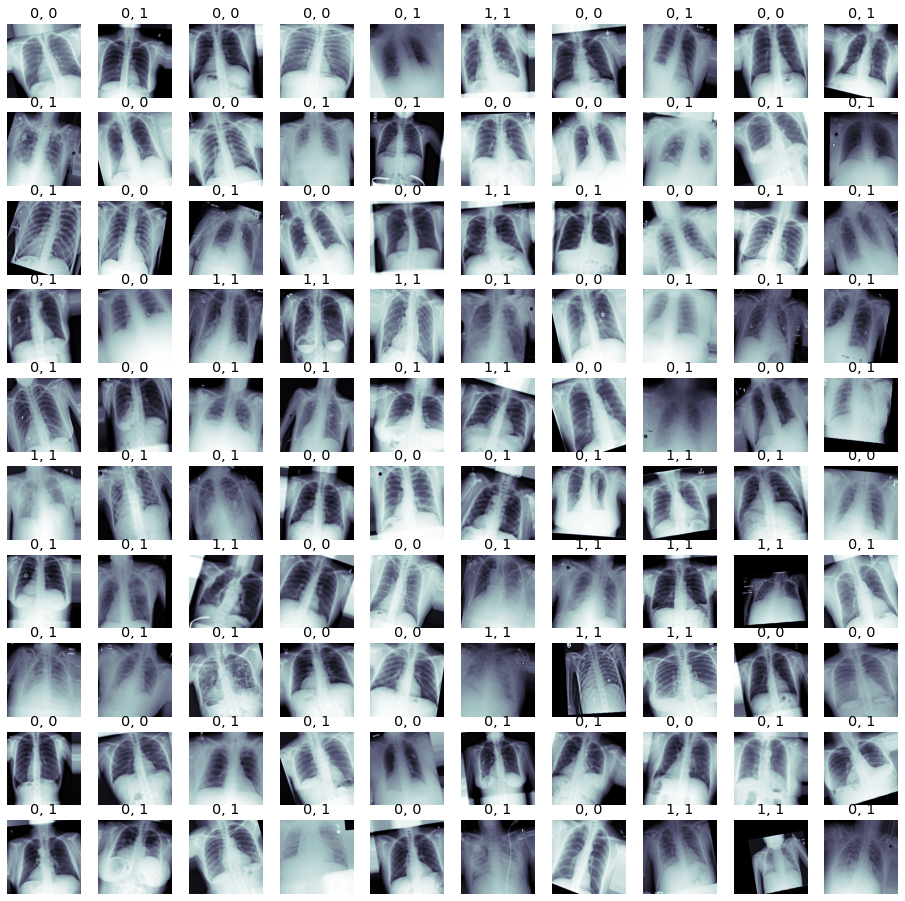

In [55]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [56]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("xray_final_model3.json", "w") as json_file:
    json_file.write(model_json)


## Summary

- The model has good recall, but very low precision, which will lead to high number of false positives.
- Therefore, it should be used only as an assitance to a radiologist, putting to low priority queue those x-rays that were classified as negative by the model. The probability of such xrays actually containing pneumonia is 9.56%

### To improve the model (future steps):
- Vary hyper-parameters:
       - dropout rate
       - augmentation parameters
       - batch size
       - learning rate
- Remove extreme intensity areas (no light, or too intensive light) from images, or use gaussian blur

